In [1]:
from numpy import array
from pickle import dump
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# load doc into memory
def load_sequences(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [3]:
# load
in_filename = 'data/trump_sequences.txt'
doc = load_sequences(in_filename)
lines = doc.split('\n')

In [4]:
# integer encode sequences of words
tokenizer = Tokenizer().fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

# define model
model = Sequential([
    Embedding(vocab_size, 50, input_length=seq_length),
    LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(256, dropout=0.2, recurrent_dropout=0.2),
    Dense(256, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 9, 50)             515250    
_________________________________________________________________
lstm (LSTM)                  (None, 9, 256)            314368    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 10305)             2648385   
Total params: 4,069,107
Trainable params: 4,069,107
Non-trainable params: 0
_________________________________________________________________


In [5]:
# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model_save = ModelCheckpoint('models/trump_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# fit model
history = model.fit(X, y, batch_size=128, epochs=100, callbacks=[early_stop, model_save], validation_split=0.1)

# save the tokenizer
dump(tokenizer, open('data/tokenizer.pkl', 'wb'))

Train on 148105 samples, validate on 16457 samples
Epoch 1/100
148105/148105 [==============================] - 37s 251us/sample - loss: 6.7596 - val_loss: 6.6894
Epoch 2/100
148105/148105 [==============================] - 32s 216us/sample - loss: 6.4081 - val_loss: 6.5897
Epoch 3/100
148105/148105 [==============================] - 33s 220us/sample - loss: 6.2615 - val_loss: 6.5043
Epoch 4/100
148105/148105 [==============================] - 32s 217us/sample - loss: 6.1478 - val_loss: 6.3962
Epoch 5/100
148105/148105 [==============================] - 32s 219us/sample - loss: 6.0660 - val_loss: 6.3699
Epoch 6/100
148105/148105 [==============================] - 33s 222us/sample - loss: 6.0101 - val_loss: 6.3983
Epoch 7/100
148105/148105 [==============================] - 33s 224us/sample - loss: 5.9687 - val_loss: 6.3105
Epoch 8/100
148105/148105 [==============================] - 33s 223us/sample - loss: 5.9265 - val_loss: 6.3181
Epoch 9/100
148105/148105 [==========================

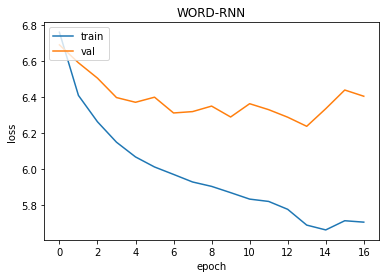

In [6]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('WORD-RNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()